In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io,scipy.misc
import os
import skimage.transform
import random
import cv2
from scipy import signal
# from PIL import Image
#img = Image.open('image.png').convert('LA')
#img.save('greyscale.png')
from scipy.signal import convolve2d
fig=plt.figure(figsize=(18, 16), dpi= 300, facecolor='w', edgecolor='k')

<Figure size 5400x4800 with 0 Axes>

In [2]:
File_names = []
for dirpath, dirnames, filenames in os.walk("/home/qian/Downloads/high_res_img/"): #############
    for filename in filenames:
        File_names.append(os.path.join(dirpath, filename))
    
img_file_names = []

print(len(File_names))

5004


In [3]:
image_size1 = 512
image_size2 = 512
Num_of_data = 5#000###########################################
#Focus_step = 200

In [4]:
DATA = np.zeros([Num_of_data,image_size1,image_size2,1], dtype=np.float16)
Label = np.zeros([Num_of_data,2],np.float16)
# In[6]:

In [5]:
Ground_truth_space = [475, 500, 525, 550, 600, 625, 650, 675, 700, 725, 800, 825, 875, 950, 1000]
Data_space = list(range(1000, 450, -25))
Data_space = Data_space[::-1]
print("Data_space size:", len(Data_space))
#print Data_space

Data_space size: 22


In [6]:
# # def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
# #     """
# #     2D gaussian mask - should give the same result as MATLAB's
# #     fspecial('gaussian',[shape],[sigma])
# #     """
# #     m,n = [(ss-1.)/2. for ss in shape]
# #     y,x = np.ogrid[-m:m+1,-n:n+1]
# #     h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
# #     h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
# #     sumh = h.sum()
# #     if sumh != 0:
# #         h /= sumh
# #     return h

# def pre_normalize(im):
#     # https://www.learnopencv.com/image-quality-assessment-brisque/
#     blurred = cv2.GaussianBlur(im, (7, 7), 1.166) # apply gaussian blur to the image
#     plt.imshow(blurred)
#     plt.show()
#     blurred_sq = blurred * blurred
#     sigma = cv2.GaussianBlur(im * im, (7, 7), 1.166) 
#     sigma = (sigma - blurred_sq) ** 0.5
#     sigma = sigma + 1.0/255 # to make sure the denominator doesn't give DivideByZero Exception
# #     plt.imshow(sigma)
# #     plt.show()
#     structdis = (im - blurred)/sigma # final MSCN(i, j) image
#     plt.imshow(im - blurred)
#     plt.show()
#     return structdis

In [7]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col= image.shape
        mean = 0
        var = 0.00
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + abs(gauss)
        return noisy
    elif noise_typ == "poisson":
        image = np.maximum(image,0)
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image*255) / float(255) + image
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy
    elif noise_typ =="None":
        return image

In [8]:
def Defocus(input_image, filter_size, scale):
    input_image = np.power(input_image,2.4)
    #print filter_size
    #print 'filters/{}.mat'.format(int(filter_size))
    #print('filters/{}.mat'.format(int(filter_size)))
    a = scipy.io.loadmat('filters/{}.mat'.format(int(filter_size)))
    h = a['h']
    pip = signal.convolve(input_image, h, mode='full', method='auto');
    pip2 = skimage.transform.rescale(pip, scale)
    M = pip2.shape[0]//2
    N = pip2.shape[1]//2
    #plt.imshow(pip2)
    #plt.show()

    #idx1 = random.randint(-200,200)''
    #idx2 = random.randint(-200,200)
    idx1 = 0
    idx2 = 0
   # print("M: {}, N: {}, imagesize1: {}, imagesize2: {}".format(M, N, image_size1, image_size2))
  #  print("pip2 shape: ", pip2.shape)
 #   print("scale = {}".format(scale))
    #print("a:{} b:{} c:{} d:{}".format((M-image_size1/2+idx1),(M+image_size1/2+idx1),(N-image_size2/2+idx2),(N+image_size2/2+idx2)))
    crop_noise = np.maximum(0,pip2[(M-image_size1//2+idx1):(M+image_size1//2+idx1),(N-image_size2//2+idx2):(N+image_size2//2+idx2)])
    #crop_noise = np.power(crop,1/2.4)#noisy("gauss",crop)
    #plt.imshow(crop)
    #plt.show()
    crop_noise = (crop_noise - crop_noise.min()) / (crop_noise.max()-crop_noise.min())
    return crop_noise

In [9]:
# In[9]:


def Data_aug(im):
    k = 360
    caseidx = random.randint(1,4)
    idx1= random.randint(-200,200) 
    idx2 =random.randint(-200,200) 
    if caseidx == 1:
        return im[im.shape[0]//2-k+idx1:im.shape[0]//2+k+idx1,im.shape[1]//2-k+idx2:im.shape[1]//2+k+idx2, :]
#     elif caseidx == 2:
#         return np.rot90(im)
    elif caseidx == 2:
        return np.rot90(np.rot90(im[im.shape[0]//2-k+idx1:im.shape[0]//2+k+idx1,im.shape[1]//2-k+idx2:im.shape[1]//2+k+idx2, :]))
#     elif caseidx == 4:
#         return np.rot90(np.rot90(np.rot90(im)))
    elif caseidx == 3:
        return np.flip(im[im.shape[0]//2-k+idx1:im.shape[0]//2+k+idx1,im.shape[1]//2-k+idx2:im.shape[1]//2+k+idx2, :],1)
#     elif caseidx == 6:
#         return np.rot90(np.flip(im,1))
    elif caseidx == 4:
        return np.rot90(np.rot90(np.flip(im[im.shape[0]//2-k+idx1:im.shape[0]//2+k+idx1,im.shape[1]//2-k+idx2:im.shape[1]//2+k+idx2, :],1)))
#     elif caseidx == 8:
#         return np.rot90(np.rot90(np.rot90(np.flip(im,1))))

In [10]:
def toBayer(img):
    # assume img is BGR pattern
    img[::2, ::2, 1] = img[::2, ::2, 2]
    img[1::2, 1::2, 1] = img[1::2, 1::2, 0]
    return img[:, :, 1]

0


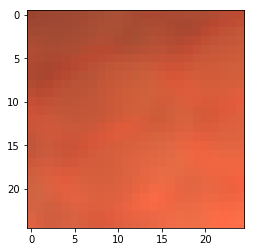

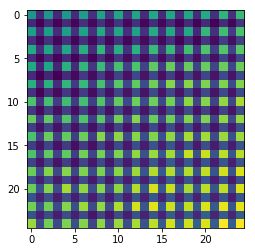

1


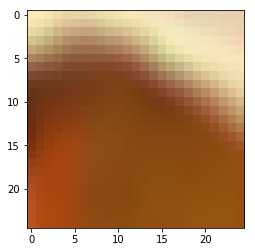

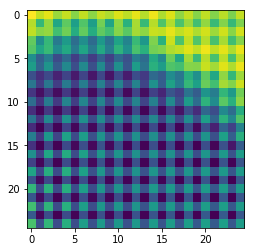

2


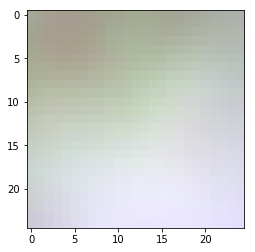

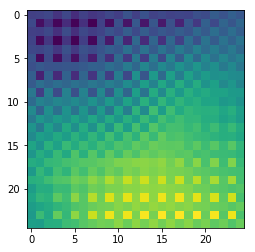

3


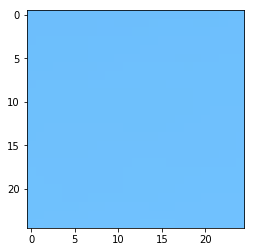

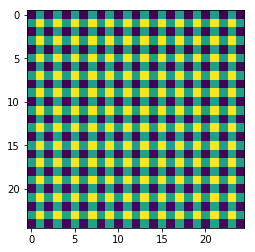

4


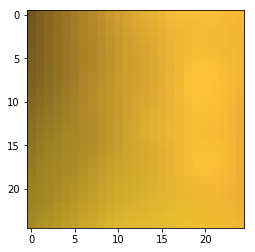

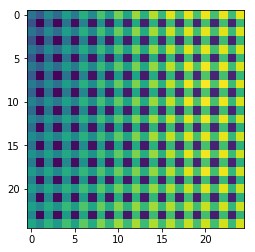

In [23]:
for i in range(Num_of_data):
    print(i)
    ## Load an image and convert it to grayscale
    idx = random.randint(0,len(File_names)-1)
    img = cv2.imread(File_names[idx])
    img_file_names.append(File_names[idx])
    while True:
        if (img is not None) and (min(img.shape[0]-1200,img.shape[1]-1200) > 0) and (len(img.shape)==3):
            break
        idx = random.randint(0,len(File_names)-1)
        img = cv2.imread(File_names[idx])
        img_file_names[i] = File_names[idx]
    Focused_image = Data_aug(img)


    if Focused_image.max()>1:
        Focused_image = Focused_image/255.0
    


    ## Generate the statistics
    
    current_position = random.choice(Ground_truth_space)
    defocus1 = random.choice(Data_space)
#     print(current_position)
#     print(defocus1)
    model_mat = scipy.io.loadmat('calibrate_raw/Model_parameters_BGR_{}.mat'.format(current_position))  ###########################
    Model_parameters_BGR = model_mat['Model_parameters_BGR']
    if defocus1 == current_position:
        DATA_ = Focused_image[Focused_image.shape[0]//2-image_size1//2:Focused_image.shape[0]//2+image_size1//2,Focused_image.shape[1]//2-image_size2//2:Focused_image.shape[1]//2+image_size2//2, :]
        plt.imshow(DATA_[:25, :25, ::-1]/DATA_[:25, :25, ::-1].max())
        plt.show()
        DATA_ = toBayer(DATA_)
        DATA_ = (DATA_ - DATA_.min())/(DATA_.max() - DATA_.min())
    else:
        DATA_ = np.zeros((512, 512, 3))
        DATA_[:, :, 0] = Defocus(Focused_image[:, :, 0],Model_parameters_BGR[Data_space.index(defocus1),2],Model_parameters_BGR[Data_space.index(defocus1),3])
        DATA_[:, :, 1] = Defocus(Focused_image[:, :, 1],Model_parameters_BGR[Data_space.index(defocus1),5],Model_parameters_BGR[Data_space.index(defocus1),6])
        DATA_[:, :, 2] = Defocus(Focused_image[:, :, 2],Model_parameters_BGR[Data_space.index(defocus1),8],Model_parameters_BGR[Data_space.index(defocus1),9])
        plt.imshow(DATA_[:25, :25, ::-1]/DATA_[:25, :25, ::-1].max())
        plt.show()
        DATA_ = toBayer(DATA_)        
        DATA_ = (DATA_ - DATA_.min())/(DATA_.max() - DATA_.min())

    Label[i,0] = Model_parameters_BGR[Data_space.index(current_position),3]
    Label[i,1] = Model_parameters_BGR[Data_space.index(defocus1),3]
    DATA[i, :, :, 0] = (DATA_).astype(np.float16)
    plt.imshow(DATA[i, :25, :25, 0].astype(np.float32))
    plt.show()
    

In [12]:
# np.save('train_data_8000_raw',DATA)    ##################################
# np.save('train_label_8000_raw',Label)  ##################################

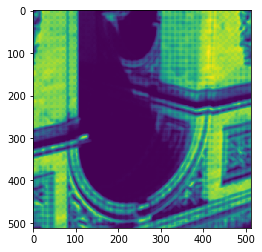

[1.    0.985]
max:  1.0 min:  0.0


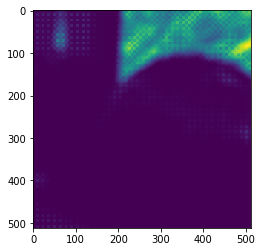

[1.    0.968]
max:  1.0 min:  0.0


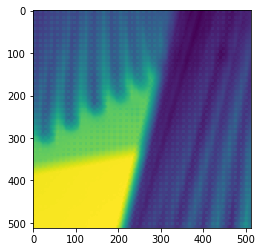

[1.    0.957]
max:  1.0 min:  0.0


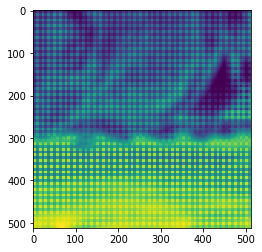

[1.    1.023]
max:  1.0 min:  0.0


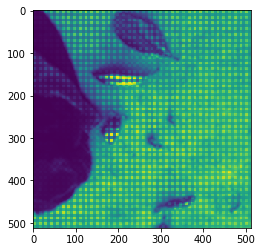

[1.    0.988]
max:  1.0 min:  0.0


IndexError: index 5 is out of bounds for axis 0 with size 5

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
for idx in range(25):
    plt.imshow(DATA[idx, :, :, 0].astype(np.float32))
    plt.show()
    print(Label[idx, :])
    print("max: ", DATA[idx,:,:,0].max(), "min: ", DATA[idx,:,:,0].min())



In [ ]:
I = cv2.imread('calibrate3/1_450_8466_s00_00000.jpg')
plt.imshow(I)
plt.show()
I2 = cv2.GaussianBlur(I, (7,7), 3)
plt.imshow(I2)
plt.show()

In [ ]:
I3 = pre_normalize(I)
plt.imshow(I3)
plt.colorbar()
plt.show()

I4 = pre_normalize(I2)
plt.imshow(I4)
plt.colorbar()
plt.show()